In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-11-20 16:33:41.241647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 16:33:41.241670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 16:33:41.241697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 16:33:41.247582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 16:33:41.785634: W tensorflow/compiler/

In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

2023-11-20 16:33:43.776648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 16:33:43.780481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 16:33:43.780630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df["headline"]= df.apply(lambda x: x['masked headline'].replace('____', str(x['ans'])), axis=1)
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [14]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object


In [15]:
train_data.head()

,news,masked headline,calculation,ans,headline,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<extra_id_0> K Walmart Part-Timers to Lose Hea...,"Paraphrase(30,000,K)",30,30K Walmart Part-Timers to Lose Health Insurance,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ex...,Copy(142),142,Dax Shepard: Wedding to Kristen Bell Cost $142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <extra_id_0> </s>,Copy(94),94,Nancy Reagan Dead at 94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<extra_id_0> M Fine f...,Copy(7),7,American Airlines Faces $7M Fine for Safety Vi...,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<extra_id_0> K Raised for Kids of Mom Dismemb...,"Paraphrase(222,000,K)",222,$222K Raised for Kids of Mom Dismembered on Date,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [16]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

In [17]:
model_name = "Michau/t5-base-en-generate-headline"

In [18]:
def preprocess_function(examples):   
    #inputs = [prefix + doc for doc in examples["news"]]
    inputs = tokenizer(examples['text'],max_length=3066,  truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=256, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [20]:
tokenized = dataset.map(preprocess_function, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

In [21]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
#optimizer = AdamWeightDecay(learning_rate=8e-5, weight_decay_rate=0.01)

In [22]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Michau/t5-base-en-generate-headline.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [23]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [24]:
model.compile(optimizer=optimizer)

In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 61s 199ms/step - loss: 0.9788
Pretrained LM Perplexity: 2.66


In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
history = model.fit(x=tf_train_set, validation_data=tf_test_set, callbacks=[callback],epochs=10)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/10
5641/5641 [==============================] - 1365s 239ms/step - loss: 0.0774 - val_loss: 0.0456
Epoch 2/10
5641/5641 [==============================] - 1358s 241ms/step - loss: 0.0415 - val_loss: 0.0460


In [19]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 53s 201ms/step - loss: 0.0442
Finetuned Perplexity: 1.05


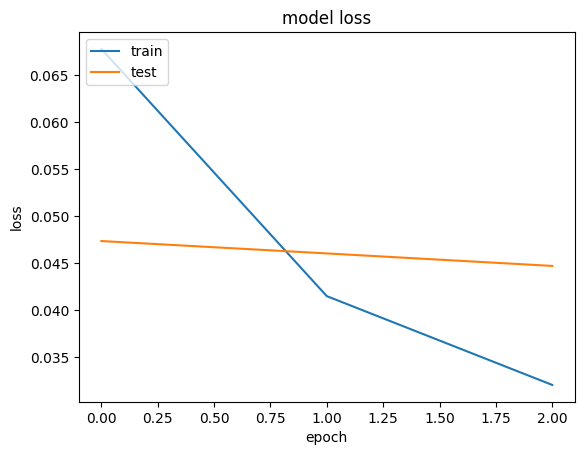

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[:200]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [27]:
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['masked headline']
    print(headline)
    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)

    _0_index = headline.index('<extra_id_0> ')
    print(_0_index)

    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    print("Pred: ", results)
    #res = re.findall(r"([\d:,./]+)", results)
    res = re.findall(r"(\d+[./]?\d*)", results[_0_index:_0_index+50])
    if len(res) < 1:
        res = re.findall(r"(\d+[./]?\d*)", results)
    try:
        return res[0]
    except:
        return None

In [28]:
tru = 0
for i in test_data:
    prediction1 = t5_predictions(i, tokenizer, model)
    answer = i['ans']
    print("Answer: ", answer)
    print("Prediction1: ", prediction1)
    print("Calc: ", i['calculation'])
    if answer == prediction1:
        tru += 1
    print("")

<extra_id_0> rd Victim Dead in Quarry Shooting; Manhunt Still On </s>


2023-11-20 17:25:22.666219: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa6dc057450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 17:25:22.666237: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-20 17:25:22.673833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-20 17:25:22.888348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-20 17:25:22.926782: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0
Pred:  3rd Victim Dead in Quarry Shooting; Manhunt Still On</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

NYT Corrects 1853 Piece After <extra_id_0>  Years Win </s>
30
Pred:  NYT Corrects 1853 Piece After 12 Years Win</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Stocks Up <extra_id_0>  in Election Rally </s>
10
Pred:  Stocks Up 305 in Election Rally</s>
Answer:  305
Prediction1:  305
Calc:  Round(305.45,0)

You Can Watch The Interview at <extra_id_0> pm </s>
31
Pred:  You Can Watch The Interview at 1pm</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Murder Suspect, <extra_id_0> , Will Stay in Adult Jail </s>
16
Pred:  Murder Suspect, 10, Will Stay in Adult Jail</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Tobacco Firms Knew of Radiation in Cigs—in <extra_id_0>  </s>
43
Pred:  Tobacco Firms Knew of Radiation in Cigs—in 1959</s>
Answer:  1959
Prediction1:  1959
Calc:  Copy(1959)

AIG Bonuses Higher Than Thought: $<extra_id_0> M </s>
34
Pred:  AIG Bonuses H

21
Pred:  Ford Surprises With $100M Q1 Profit</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

<extra_id_0>  Students Arrested After Chemical 'Device' Goes Off </s>
0
Pred:  2 Students Arrested After Chemical 'Device' Goes Off</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

<extra_id_0>  Winning Powerball Tickets Sold </s>
0
Pred:  2 Winning Powerball Tickets Sold</s>
Answer:  2
Prediction1:  2
Calc:  Add(Span(Arizona),Span(Missouri))

Humans Push Earth Past <extra_id_0>  of 9 Danger Zones </s>
23
Pred:  Humans Push Earth Past 4 of 9 Danger Zones</s><pad>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Floridian Is Now <extra_id_0> rd to Die of Seawater Bacteria </s>
17
Pred:  Floridian Is Now 3rd to Die of Seawater Bacteria</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Clintons Near Deal on $<extra_id_0> M Country Mansion </s>
23
Pred:  Clintons Near Deal on $11M Country Mansion</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Periodic Table Gets <extra_id_0>  New Elements

19
Pred:  Shakespeare Gets an 400-Year-Old Drug Test</s>
Answer:  400
Prediction1:  400
Calc:  Copy(400)

Elizabeth Edwards Dead at <extra_id_0>  </s>
26
Pred:  Elizabeth Edwards Dead at 61</s>
Answer:  61
Prediction1:  61
Calc:  Copy(61)

New EU Sanctions Hit Maker of AK-<extra_id_0>  </s>
33
Pred:  New EU Sanctions Hit Maker of AK-47</s>
Answer:  47
Prediction1:  47
Calc:  Copy(47)

Zimmerman Sues NBC Over <extra_id_0>  Tape Edits </s>
24
Pred:  Zimmerman Sues NBC Over 911 Tape Edits</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

Big <extra_id_0>  Execs Finish With Senate </s>
4
Pred:  Big 3 Execs Finish With Senate</s>
Answer:  3
Prediction1:  3
Calc:  Trans(Three)

Texas Performs <extra_id_0> th Execution </s>
15
Pred:  Texas Performs 500th Execution</s>
Answer:  500
Prediction1:  500
Calc:  Copy(500)

Some of the New $<extra_id_0>  Bills Will Be Worth $1K—or More </s>
17
Pred:  Some of the New $100 Bills Will Be Worth $1K—or More</s>
Answer:  100
Prediction1:  100
Calc:

31
Pred:  Aussie Aerial Shoot Could Cull 1M Camels</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Romney's Cash Edge: $<extra_id_0> M </s>
21
Pred:  Romney's Cash Edge: $91M</s>
Answer:  62
Prediction1:  91
Calc:  Subtract(186,124)

Coke Bids $<extra_id_0> B for Chinese Juice Company </s>
11
Pred:  Coke Bids $2.4B for Chinese Juice Company</s>
Answer:  2.4
Prediction1:  2.4
Calc:  Copy(2.4)

Stimulus Gave $<extra_id_0> M to Faith-Based Groups </s>
15
Pred:  Stimulus Gave $140M to Faith-Based Groups</s>
Answer:  140
Prediction1:  140
Calc:  Copy(140)

Google Maps Reunites Boy With Family, <extra_id_0>  Years Later </s>
38
Pred:  Google Maps Reunites Boy With Family, 23 Years Later</s>
Answer:  23
Prediction1:  23
Calc:  Copy(23)

<extra_id_0> K Feared Dead in Turkey Quake </s>
0
Pred:  1K Feared Dead in Turkey Quake</s><pad>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

<extra_id_0> K-Year-Old Bone Spills Beans on Human-Neanderthal Sex </s>
0
Pred:  45K-Year-Old Bone Spill

31
Pred:  Facebook: Defining Religion in 100 Characters</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

China Quarantines <extra_id_0>  Yanks </s>
18
Pred:  China Quarantines 2 Yanks</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Dow Ends Day Up <extra_id_0>  </s>
16
Pred:  Dow Ends Day Up 22</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

Court: Man in Solitary Since <extra_id_0>  Can Be Tried 3rd Time </s>
29
Pred:  Court: Man in Solitary Since 1972 Can Be Tried 3rd Time</s>
Answer:  1972
Prediction1:  1972
Calc:  Copy(1972)

Fed Launches $<extra_id_0> B Programs to Unlock Lending </s>
14
Pred:  Fed Launches $200B Programs to Unlock Lending</s>
Answer:  800
Prediction1:  200
Calc:  Add(200,600)

'Terrifying' Glass Slide Hangs <extra_id_0> K Feet Above LA </s>
31
Pred:  'Terrifying' Glass Slide Hangs 1K Feet Above LA</s><pad>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

American Was Among <extra_id_0>  Climbers Slain By Taliban </s>
19
Pred:  American Was Amon

19
Pred:  Man May Have Paid $55K to Kill Africa's Most Famous Lion</s>
Answer:  55
Prediction1:  55
Calc:  Paraphrase(55,000,K)

Vet Stands on Bridge <extra_id_0>  Hours to Honor Victims in Tennessee </s>
21
Pred:  Vet Stands on Bridge 4 Hours to Honor Victims in Tennessee</s><pad>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Man Willing to Lose Job Over <extra_id_0> -Minute Diversity Video </s>
29
Pred:  Man Willing to Lose Job Over 17-Minute Diversity Video</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Romney to Say If He's Running at <extra_id_0> am </s>
33
Pred:  Romney to Say If He's Running at 11am</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

<extra_id_0> nd Known Photo of Emily Dickinson Surfaces </s>
0
Pred:  2nd Known Photo of Emily Dickinson Surfaces</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

Berlusconi Sex Trial Adjourned After <extra_id_0>  Minutes </s>
37
Pred:  Berlusconi Sex Trial Adjourned After 7 Minutes</s>
Answer:  7
Prediction1:  7
Calc:  T

29
Pred:  Americans Elect on Ballot in 17 States and Counting</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Here's Who's Getting What From Bowie's $<extra_id_0> M Estate </s>
40
Pred:  Here's Who's Getting What From Bowie's $100M Estate</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

IPO Talks Peg Value of Groupon at Staggering $<extra_id_0> B </s>
46
Pred:  IPO Talks Peg Value of Groupon at Staggering $15B</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

<extra_id_0> K Americans at Risk for Female Genital Mutilation </s>
0
Pred:  513K Americans at Risk for Female Genital Mutilation</s>
Answer:  500
Prediction1:  513
Calc:  Paraphrase(513,000,K)

It's Tough to Be Conservative Enough in <extra_id_0>  </s>
40
Pred:  It's Tough to Be Conservative Enough in 2010</s>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Area <extra_id_0>  Has a Top-Secret Neighbor Base </s>
5
Pred:  Area 6 Has a Top-Secret Neighbor Base</s>
Answer:  51
Prediction1:  6
Calc:  Copy(51)

DA: Doc Mastur

45
Pred:  Beyonce Shoutout Spikes Red Lobster Sales by 33%</s>
Answer:  33
Prediction1:  33
Calc:  Copy(33)

US Malaria Experiments in <extra_id_0> s Left Troops 'Ruined' </s>
26
Pred:  US Malaria Experiments in 1940s Left Troops 'Ruined'</s><pad>
Answer:  1940
Prediction1:  1940
Calc:  Copy(1940)

Teen: Berlusconi Gave Me $<extra_id_0> K </s>
26
Pred:  Teen: Berlusconi Gave Me $9K</s><pad>
Answer:  9
Prediction1:  9
Calc:  Round(Paraphrase(9,350,K),0)

Burger King Brings Back Yumbo—After <extra_id_0>  Years </s>
36
Pred:  Burger King Brings Back Yumbo—After 45 Years</s>
Answer:  40
Prediction1:  45
Calc:  Subtract(2014,1974)

<extra_id_0> K Apply for 877 Hyundai Jobs in Alabama </s>
0
Pred:  20K Apply for 877 Hyundai Jobs in Alabama</s><pad>
Answer:  20
Prediction1:  20
Calc:  Paraphrase(20,000,K)

Now-Rare Malia, Sasha Dolls Go for $<extra_id_0> K </s>
36
Pred:  Now-Rare Malia, Sasha Dolls Go for $3K</s><pad>
Answer:  3
Prediction1:  3
Calc:  Paraphrase(3,000,K)

Pitt Hit With <extra

20
Pred:  Steven Tyler Snags $2M for Memoir</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Carnival Samba Queen, <extra_id_0> , Breaks Down </s>
22
Pred:  Carnival Samba Queen, 7, Breaks Down</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

South African Named Miss World <extra_id_0>  </s>
31
Pred:  South African Named Miss World 2014</s>
Answer:  2014
Prediction1:  2014
Calc:  Copy(2014)

4 Shot, <extra_id_0>  Killed at NYC Rap Concert </s>
8
Pred:  4 Shot, 1 Killed at NYC Rap Concert</s>
Answer:  1
Prediction1:  1
Calc:  Trans(One)

Austrian Man Held Daughter Captive <extra_id_0>  Years </s>
35
Pred:  Austrian Man Held Daughter Captive 24 Years</s>
Answer:  24
Prediction1:  24
Calc:  Copy(24)

Boy, <extra_id_0> , Survives 5-Organ Transplant </s>
5
Pred:  Boy, 3, Survives 5-Organ Transplant</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Europe Storm Leaves <extra_id_0>  Dead </s>
20
Pred:  Europe Storm Leaves 11 Dead</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

<extr

43
Pred:  Colossal Chinese Dustball Circles Earth in 13 Days</s>
Answer:  13
Prediction1:  13
Calc:  Copy(13)

<extra_id_0>  US Troops Killed in Attack on Afghan Base </s>
0
Pred:  2 US Troops Killed in Attack on Afghan Base</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Voice of Judy Jetson Dies at Age <extra_id_0>  </s>
33
Pred:  Voice of Judy Jetson Dies at Age 96</s>
Answer:  96
Prediction1:  96
Calc:  Copy(96)

Saudis Bumping Oil Flow <extra_id_0> % to Slow Soaring Prices </s>
24
Pred:  Saudis Bumping Oil Flow 2% to Slow Soaring Prices</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

<extra_id_0> -Year-Old Skeleton Removed From Woman, 62 </s>
0
Pred:  38-Year-Old Skeleton Removed From Woman, 62</s>
Answer:  38
Prediction1:  38
Calc:  Copy(38)

Doing Porn Should Be Like Buying Booze: <extra_id_0> + Only </s>
40
Pred:  Doing Porn Should Be Like Buying Booze: 18+ Only</s>
Answer:  21
Prediction1:  18
Calc:  Copy(21)

Ex-Nazi, 90, Charged With <extra_id_0>  Murders </s>
26
Pred:  Ex-Naz

16
Pred:  Oil Dips Below $100 for First Time in 5 Months</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Fracking Quakes Could Be Avoided ... for $<extra_id_0> M Per Well </s>
42
Pred:  Fracking Quakes Could Be Avoided ... for $10M Per Well</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

<extra_id_0>  Cops Fired After Pulling Students From Car Amid Protest </s>
0
Pred:  2 Cops Fired After Pulling Students From Car Amid Protest</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

WikiLeaks Dumps <extra_id_0> M Syria Emails </s>
16
Pred:  WikiLeaks Dumps 2.4M Syria Emails</s>
Answer:  2.4
Prediction1:  2.4
Calc:  Copy(2.4)

Sheriff Joe Arpaio's Office Failed to Properly Investigate More than <extra_id_0>  Sex Crimes Cases </s>
69
Pred:  Sheriff Joe Arpaio's Office Failed to Properly Investigate More than 400 Sex Crimes Cases</s>
Answer:  400
Prediction1:  400
Calc:  Copy(400)

Cain's Other Harassment Settlement: $<extra_id_0> K </s>
37
Pred:  Cain's Other Harassment Settlement: $45K<

12
Pred:  Syria Frees 260 Detainees as Protests Resume</s>
Answer:  260
Prediction1:  260
Calc:  Copy(260)

Ex-NBA Star Jayson Williams Gets <extra_id_0>  Months in Driver's Death </s>
33
Pred:  Ex-NBA Star Jayson Williams Gets 18 Months in Driver's Death</s>
Answer:  18
Prediction1:  18
Calc:  Copy(18)

Royals' Tejada Suspended <extra_id_0>  Games for Drugs </s>
25
Pred:  Royals' Tejada Suspended 105 Games for Drugs</s>
Answer:  105
Prediction1:  105
Calc:  Copy(105)

<extra_id_0> -Lb Man Biking Across US to Save His Marriage </s>
0
Pred:  560-Lb Man Biking Across US to Save His Marriage</s>
Answer:  560
Prediction1:  560
Calc:  Copy(560)

<extra_id_0> nd Athlete Booted From Games Over Racist Tweet </s>
0
Pred:  2nd Athlete Booted From Games Over Racist Tweet</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Boys, <extra_id_0> : Janitors Tied Us in Bathroom </s>
6
Pred:  Boys, 10: Janitors Tied Us in Bathroom</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

The Big World Events You

5
Pred:  1 in 5 Homes Have Student Debt</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

MoveOn Raises $<extra_id_0> M to Fight Lieberman </s>
15
Pred:  MoveOn Raises $1M to Fight Lieberman</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

$<extra_id_0> M Mansion Sinks Hearst Heiress </s>
1
Pred:  $30M Mansion Sinks Hearst Heiress</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

Roller Coaster Triggers Stroke in <extra_id_0> -Year-Old </s>
34
Pred:  Roller Coaster Triggers Stroke in 4-Year-Old</s><pad>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

NJ Town Wants Entire Downtown Raised <extra_id_0>  Feet </s>
37
Pred:  NJ Town Wants Entire Downtown Raised 10 Feet</s>
Answer:  11
Prediction1:  10
Calc:  Copy(11)

Antarctic Iceberg Is <extra_id_0>  Times Size of Manhattan </s>
21
Pred:  Antarctic Iceberg Is 6 Times Size of Manhattan</s><pad>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Charities Take Biggest Hit in <extra_id_0>  Years </s>
30
Pred:  Charities Take Biggest Hit in 20

0
Pred:  2nd American Woman Among Terror Arrests</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

Beer Tent Owner: Obama Visit Cost Me $<extra_id_0> K </s>
38
Pred:  Beer Tent Owner: Obama Visit Cost Me $25K</s><pad>
Answer:  25
Prediction1:  25
Calc:  Paraphrase(25,000,K)

Chicago Train Jumps Tracks, Climbs Escalator, Injuring <extra_id_0>  </s>
55
Pred:  Chicago Train Jumps Tracks, Climbs Escalator, Injuring 32</s>
Answer:  32
Prediction1:  32
Calc:  Trans(Thirty-two)

Georgia Executes Killer Who Buried Victim in <extra_id_0>  States </s>
45
Pred:  Georgia Executes Killer Who Buried Victim in 2 States</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Egypt Throws Book at <extra_id_0>  for Tahrir Square Sex Assaults </s>
21
Pred:  Egypt Throws Book at 9 for Tahrir Square Sex Assaults</s><pad>
Answer:  9
Prediction1:  9
Calc:  Trans(nine)

'Terminally Ill? $<extra_id_0> K in CASH' Schemers Profit Off of Death </s>
18
Pred:  'Terminally Ill? $2K in CASH' Schemers Profit Off of 

27
Pred:  Crisis Powwow Set for Nov. 15</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

Men Hit With <extra_id_0> % of US Layoffs </s>
13
Pred:  Men Hit With 80% of US Layoffs</s>
Answer:  80
Prediction1:  80
Calc:  Copy(80)

Cheesemaking Goes Back <extra_id_0> K Years </s>
23
Pred:  Cheesemaking Goes Back 7K Years</s><pad>
Answer:  7.5
Prediction1:  7
Calc:  Paraphrase(7,500,K)

India Arrests <extra_id_0>  in US Woman's Rape </s>
14
Pred:  India Arrests 3 in US Woman's Rape</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Secret Service Grills Kid, <extra_id_0> , on Facebook Post </s>
27
Pred:  Secret Service Grills Kid, 13, on Facebook Post</s><pad>
Answer:  13
Prediction1:  13
Calc:  Copy(13)

Mom of Dutch Sailor, <extra_id_0> : OK, She Can Go </s>
21
Pred:  Mom of Dutch Sailor, 14: OK, She Can Go</s>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

Girl, <extra_id_0> , Dead After Swallowing Battery </s>
6
Pred:  Girl, 2, Dead After Swallowing Battery</s>
Answer:  2
Prediction1:  

29
Pred:  'Lost' Man Booker Prize From 1970 to Be Awarded</s>
Answer:  1970
Prediction1:  1970
Calc:  Copy(1970)

Red Cross: <extra_id_0>  Killed in Nigeria University Attack </s>
11
Pred:  Red Cross: 16 Killed in Nigeria University Attack</s>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Novelist Jose Saramago Dead at <extra_id_0>  </s>
31
Pred:  Novelist Jose Saramago Dead at 87</s>
Answer:  87
Prediction1:  87
Calc:  Copy(87)

Rare Raphael Drawing Goes for $<extra_id_0> M </s>
31
Pred:  Rare Raphael Drawing Goes for $48M</s>
Answer:  48
Prediction1:  48
Calc:  Copy(48)

Wendy's Return to Japan Marked by ... a $<extra_id_0>  Burger </s>
41
Pred:  Wendy's Return to Japan Marked by ... a $16 Burger</s>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Police Reveal <extra_id_0>  Murder Victim's Last Words </s>
14
Pred:  Police Reveal 1988 Murder Victim's Last Words</s>
Answer:  1988
Prediction1:  1988
Calc:  Copy(1988)

Boy Had Lego Stuck Up Nose for <extra_id_0>  Years </s>
31
Pred:  Boy 

20
Pred:  Credit Stimulus for 650K Jobs: White House</s>
Answer:  650
Prediction1:  650
Calc:  Paraphrase(650,000,K)

Why Two Friends Hugged for <extra_id_0>  Hours </s>
27
Pred:  Why Two Friends Hugged for 31 Hours</s>
Answer:  31
Prediction1:  31
Calc:  Copy(31)

Officials: Texas Needs $<extra_id_0> B From Feds for Ike Cleanup </s>
24
Pred:  Officials: Texas Needs $40B From Feds for Ike Cleanup</s><pad>
Answer:  40
Prediction1:  40
Calc:  Copy(40)

<extra_id_0> K Rescued From Ike; Houston Enacts Curfew </s>
0
Pred:  2K Rescued From Ike; Houston Enacts Curfew</s><pad>
Answer:  2
Prediction1:  2
Calc:  Paraphrase(2,000,K)

Qantas: Half of World's A<extra_id_0> s Need Engines Replaced </s>
25
Pred:  Qantas: Half of World's A380s Need Engines Replaced</s><pad>
Answer:  380
Prediction1:  380
Calc:  Copy(380)

<extra_id_0>  Missing, 8 Dead in Sierra Leone Boat Accident </s>
0
Pred:  200 Missing, 8 Dead in Sierra Leone Boat Accident</s><pad>
Answer:  221
Prediction1:  200
Calc:  Copy(221)



32
Pred:  Sleek New Drone Flies Over Area 51</s><pad><pad><pad><pad><pad>
Answer:  51
Prediction1:  51
Calc:  Copy(51)

Penn State Plays <extra_id_0> st Game Since Sex Scandal </s>
17
Pred:  Penn State Plays 1st Game Since Sex Scandal</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Lady Gaga Sells <extra_id_0> M  Born This Way  in First Week </s>
16
Pred:  Lady Gaga Sells 1.11M Born This Way in First Week</s>
Answer:  1.1
Prediction1:  1.11
Calc:  Round(1.11,1)

<extra_id_0>  Dead in Buffalo Restaurant Shooting </s>
0
Pred:  4 Dead in Buffalo Restaurant Shooting</s>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Mexico Fears <extra_id_0> st Fatality Spread Flu Widely </s>
13
Pred:  Mexico Fears 1st Fatality Spread Flu Widely</s>
Answer:  1
Prediction1:  1
Calc:  Trans(first)

<extra_id_0>  Years a Slave a Film 'for the Ages' </s>
0
Pred:  12 Years a Slave a Film 'for the Ages'</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

<extra_id_0>  Gadhafi Supporters Apparently Executed </s>
0
P

47
Pred:  Cops Found Bomb Materials in Shooter's Home in 2006</s>
Answer:  2006
Prediction1:  2006
Calc:  Copy(2006)

No. <extra_id_0> : Florida Sen. Nelson Backs Gay Marriage </s>
4
Pred:  No. 51: Florida Sen. Nelson Backs Gay Marriage</s>
Answer:  51
Prediction1:  51
Calc:  Copy(51)

Crabber Saves <extra_id_0>  Kids, 8 Adults From Sunken Boat </s>
14
Pred:  Crabber Saves 14 Kids, 8 Adults From Sunken Boat</s>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

US Sending <extra_id_0>  'Military Advisers' to Iraq </s>
11
Pred:  US Sending 300 'Military Advisers' to Iraq</s>
Answer:  300
Prediction1:  300
Calc:  Copy(300)

Baltimore Murder Count Hits <extra_id_0> -Year High </s>
28
Pred:  Baltimore Murder Count Hits 40-Year High</s>
Answer:  43
Prediction1:  40
Calc:  Copy(43)

Obama Wants <extra_id_0> nd Fed Term for Bernanke </s>
12
Pred:  Obama Wants 2nd Fed Term for Bernanke</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

How <extra_id_0>  Nazi POWs Escaped Into the Wilds of Mi

22
Pred:  Greyhound Crash Kills 1, Injures Dozens</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

UK Slaying Suspect Detained in <extra_id_0>  —in Kenya </s>
31
Pred:  UK Slaying Suspect Detained in 2010—in Kenya</s><pad>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Time Runs Out for Lakers in Game <extra_id_0>  Loss to Celtics </s>
33
Pred:  Time Runs Out for Lakers in Game 2 Loss to Celtics</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Ground Zero Mosque Applied for $<extra_id_0> M 9/11 Grant </s>
32
Pred:  Ground Zero Mosque Applied for $5M 9/11 Grant</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Texas Pulls <extra_id_0>  Kids From Sect Compound </s>
12
Pred:  Texas Pulls 52 Kids From Sect Compound</s><pad>
Answer:  52
Prediction1:  52
Calc:  Copy(52)

Mexican Drug Boss: I Ordered <extra_id_0>  Murders </s>
29
Pred:  Mexican Drug Boss: I Ordered 1,500 Murders</s>
Answer:  1,500
Prediction1:  1
Calc:  Copy(1,500)

Zuckerberg Giving Himself <extra_id_0>  Months Paternity Leave

25
Pred:  Coming Soon to Detroit: $8K RoboCop Statue?</s><pad>
Answer:  80
Prediction1:  8
Calc:  Paraphrase(80,000,k)

Iowa CEO Pleads Guilty in $<extra_id_0> M Fraud </s>
27
Pred:  Iowa CEO Pleads Guilty in $100M Fraud</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

West Nile Death Toll Hits <extra_id_0>  </s>
26
Pred:  West Nile Death Toll Hits 66</s>
Answer:  66
Prediction1:  66
Calc:  Copy(66)

3 Cheetahs, <extra_id_0>  Cubs, One 'Big Breakthrough' </s>
12
Pred:  3 Cheetahs, 2 Cubs, One 'Big Breakthrough'</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

The Grim Way That H<extra_id_0> N9 Kills </s>
19
Pred:  The Grim Way That H7N9 Kills</s>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Bladerunner Sets Sights on <extra_id_0>  Olympics </s>
27
Pred:  Bladerunner Sets Sights on 2012 Olympics</s>
Answer:  2012
Prediction1:  2012
Calc:  Copy(2012)

Crypt Above Monroe's Sells for $<extra_id_0> M </s>
32
Pred:  Crypt Above Monroe's Sells for $4.6M</s>
Answer:  4.6
Prediction1:  4.6
C

44
Pred:  Scientists Argue That 'Age of Man' Began in 1610</s>
Answer:  1610
Prediction1:  1610
Calc:  Copy(1610)

Crack Team of Scientists' Goal: 'Make 100 the New <extra_id_0> ' </s>
50
Pred:  Crack Team of Scientists' Goal: 'Make 100 the New 60'</s>
Answer:  60
Prediction1:  60
Calc:  Copy(60)

Police Copters Collide, <extra_id_0>  Hurt </s>
24
Pred:  Police Copters Collide, 5 Hurt</s>
Answer:  6
Prediction1:  5
Calc:  Add(Trans(five), 1)

Grown Ups <extra_id_0> , After Earth Lead Razzie Noms </s>
10
Pred:  Grown Ups 2, After Earth Lead Razzie Noms</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Two Gamblers Take NJ Casino for $<extra_id_0> M </s>
33
Pred:  Two Gamblers Take NJ Casino for $5M</s><pad>
Answer:  11
Prediction1:  5
Calc:  Round(Add(5.8,5.3),0)

<extra_id_0>  NYPD Officers Shot After Argument Over Elevator </s>
0
Pred:  4 NYPD Officers Shot After Argument Over Elevator</s>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Less Than a Minute of Footage Was Posted. <extra_id

0
Pred:  2 More Officers Terminated After Parkland Probe</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Visiting Brit: I Bought $<extra_id_0> M Warhol at a Garage Sale </s>
25
Pred:  Visiting Brit: I Bought $2M Warhol at a Garage Sale</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

eBay Snaps Up Hunch for $<extra_id_0> M </s>
25
Pred:  eBay Snaps Up Hunch for $80M</s>
Answer:  80
Prediction1:  80
Calc:  Copy(80)

Pakistan Bomber Kills <extra_id_0>  </s>
22
Pred:  Pakistan Bomber Kills 31</s><pad>
Answer:  31
Prediction1:  31
Calc:  Copy(31)

Without Answers, <extra_id_0>  Probe Could Stretch Into 'Weeks' </s>
17
Pred:  Without Answers, 787 Probe Could Stretch Into 'Weeks'</s>
Answer:  787
Prediction1:  787
Calc:  Copy(787)

Turns Out There Were <extra_id_0>  Issues With Celeb's Birthday Faux Pas </s>
21
Pred:  Turns Out There Were 2 Issues With Celeb's Birthday Faux Pas</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Toy Story 3 Romps in $<extra_id_0> M Debut </s>
22
Pred

0
Pred:  3 Days After Crash Kills Girlfriend, Man Crawls From Wreck</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

BP Cleanup Tab Passes $<extra_id_0> B Mark </s>
23
Pred:  BP Cleanup Tab Passes $3B Mark</s><pad>
Answer:  3
Prediction1:  3
Calc:  Round(3.12,0)

Arby's Airs a <extra_id_0> -Hour Commercial </s>
14
Pred:  Arby's Airs a 13-Hour Commercial</s>
Answer:  13
Prediction1:  13
Calc:  Copy(13)

Last '<extra_id_0>  Session Starts Flat </s>
6
Pred:  Last '08 Session Starts Flat</s>
Answer:  08
Prediction1:  08
Calc:  Subtract(2008,2000)

United Flight Hits Turbulence, Injuring <extra_id_0>  </s>
40
Pred:  United Flight Hits Turbulence, Injuring 30</s>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

<extra_id_0>  Dead in Christmas Shooting </s>
0
Pred:  7 Dead in Christmas Shooting</s>
Answer:  7
Prediction1:  7
Calc:  Trans(seven)

NC Cops Arrest <extra_id_0> nd Man in Craigslist Rape </s>
15
Pred:  NC Cops Arrest 2nd Man in Craigslist Rape</s><pad>
Answer:  2
Prediction1:  2
Ca

34
Pred:  For Gay Man Kicked Out of Army in 1955, Vindication</s>
Answer:  1955
Prediction1:  1955
Calc:  Copy(1955)

Dotcom Web Domain Turns <extra_id_0>  </s>
24
Pred:  Dotcom Web Domain Turns 25</s>
Answer:  25
Prediction1:  25
Calc:  Copy(25)

Cops: <extra_id_0>  Men Tried to Swipe Utility Pole Post-Irma </s>
6
Pred:  Cops: 2 Men Tried to Swipe Utility Pole Post-Irma</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Stocks in China Have Best Day in <extra_id_0>  Years </s>
33
Pred:  Stocks in China Have Best Day in 6 Years</s><pad>
Answer:  6
Prediction1:  6
Calc:  Copy(6)

Fed Spurs Rally; Dow Up <extra_id_0>  </s>
24
Pred:  Fed Spurs Rally; Dow Up 120</s><pad>
Answer:  120
Prediction1:  120
Calc:  Copy(120)

Turkey: <extra_id_0>  Dead, Thousands Arrested as Coup Quashed </s>
8
Pred:  Turkey: 161 Dead, Thousands Arrested as Coup Quashed</s>
Answer:  161
Prediction1:  161
Calc:  Copy(161)

Noda Gain: Japan Gets 6th Leader in <extra_id_0>  Years </s>
36
Pred:  Noda Gain: Japan Gets 

34
Pred:  Teen Charged With Beating, Raping 85-Year-Old Nun</s>
Answer:  85
Prediction1:  85
Calc:  Copy(85)

Elie Tahari Manager's $<extra_id_0> M Lawsuit: Exile to New Jersey Drove Me to Mental Breakdown </s>
23
Pred:  Elie Tahari Manager's $2M Lawsuit: Exile to New Jersey Drove Me to Mental Breakdown</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Toddler Falls <extra_id_0>  Stories—and Woman Catches Her </s>
14
Pred:  Toddler Falls 10 Stories—and Woman Catches Her</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Maryland Shocks No. <extra_id_0>  UNC </s>
20
Pred:  Maryland Shocks No. 1 UNC</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

<extra_id_0>  Killed as Throngs Mourn Egypt's Coptic Pope </s>
0
Pred:  3 Killed as Throngs Mourn Egypt's Coptic Pope</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Man Missing Since <extra_id_0>  Found in Pond by Funeral Home </s>
18
Pred:  Man Missing Since 2006 Found in Pond by Funeral Home</s>
Answer:  2006
Prediction1:  2006
Calc:  Cop

5
Pred:  Boy, 10, Escaped Hudson Mom's Van by Window</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Sorry, Kids: No $<extra_id_0>  iPhone at Wal-Mart </s>
17
Pred:  Sorry, Kids: No $99 iPhone at Wal-Mart</s>
Answer:  99
Prediction1:  99
Calc:  Copy(99)

Journalists Held in N. Korea Face <extra_id_0>  Years' Labor </s>
34
Pred:  Journalists Held in N. Korea Face 10 Years' Labor</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

No. <extra_id_0>  US Nuke Chief Suspended </s>
4
Pred:  No. 2 US Nuke Chief Suspended</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Aviation Industry Will Need 617K New Pilots by <extra_id_0>  </s>
47
Pred:  Aviation Industry Will Need 617K New Pilots by 2035</s>
Answer:  2035
Prediction1:  2035
Calc:  Copy(2035)

<extra_id_0>  Dead in Turkey 'Blood Feud' Strike </s>
0
Pred:  45 Dead in Turkey 'Blood Feud' Strike</s>
Answer:  45
Prediction1:  45
Calc:  Copy(45)

Cops: Yuma Gunman, <extra_id_0> , Kills 5, Himself Over Divorce </s>
19
Pred:  Cops: Yuma

37
Pred:  Youngest Gitmo Detainee, Captured at 14, Goes Free</s><pad>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

Afghan Rocket Misses French General, Kills <extra_id_0>  Kids </s>
43
Pred:  Afghan Rocket Misses French General, Kills 3 Kids</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

President Obama Looks to North Carolina, Virginia, Mountain West for <extra_id_0>  Election </s>
69
Pred:  President Obama Looks to North Carolina, Virginia, Mountain West for 2012 Election</s>
Answer:  2012
Prediction1:  2012
Calc:  Copy(2012)

Coraline Scares in Stunning <extra_id_0> -D </s>
28
Pred:  Coraline Scares in Stunning 3-D</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Watch 100 YouTube Classics in <extra_id_0>  Minutes </s>
30
Pred:  Watch 100 YouTube Classics in 4 Minutes</s><pad>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Study: <extra_id_0> % of Obese Will Still Be Obese Next Year </s>
7
Pred:  Study: 0.5% of Obese Will Still Be Obese Next Year</s>
Answer:  99.5
Prediction1: 

0
Pred:  7K Patients of Dentist Told to Get Tested for HIV</s><pad>
Answer:  7
Prediction1:  7
Calc:  Paraphrase(7,000,K)

Record 70 Journalists Killed in <extra_id_0>  </s>
32
Pred:  Record 70 Journalists Killed in 2012</s>
Answer:  2009
Prediction1:  2012
Calc:  Subtract(2010,Span(last year))

Al-Qaeda Vows 'Death By <extra_id_0>  Cuts' </s>
24
Pred:  Al-Qaeda Vows 'Death By 1,000 Cuts'</s><pad>
Answer:  1,000
Prediction1:  1
Calc:  Trans(a thousand)

The 'Fifth Beatle' Is Dead at <extra_id_0>  </s>
30
Pred:  The 'Fifth Beatle' Is Dead at 90</s><pad>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

Bloomberg Might Actually Run for President in <extra_id_0>  </s>
46
Pred:  Bloomberg Might Actually Run for President in 2016</s>
Answer:  2016
Prediction1:  2016
Calc:  Copy(2016)

Obama Grabs <extra_id_0> -Point Lead in Poll </s>
12
Pred:  Obama Grabs 6-Point Lead in Poll</s>
Answer:  6
Prediction1:  6
Calc:  Copy(6)

Another Ohio Captivity Case: Woman, Child Held <extra_id_0>  Years </s>
4

0
Pred:  21 Prostitutes May Have Visited Secret Service Hotel</s>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

Somali Pirates on Hijacking Spree, Capture <extra_id_0>  Ships </s>
43
Pred:  Somali Pirates on Hijacking Spree, Capture 5 Ships</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Mass. Man Held in Rape of <extra_id_0> -Year-Old </s>
26
Pred:  Mass. Man Held in Rape of 2-Year-Old</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

NYT Corrects <extra_id_0>  Piece After 12 Years Win </s>
13
Pred:  NYT Corrects 1853 Piece After 12 Years Win</s><pad>
Answer:  1853
Prediction1:  1853
Calc:  Copy(1853)

Dolly Strengthens to Category <extra_id_0>  </s>
30
Pred:  Dolly Strengthens to Category 2</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Nepali Goddess Retires at <extra_id_0>  </s>
26
Pred:  Nepali Goddess Retires at 11</s><pad><pad>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Alfalfa Sprouts Linked to <extra_id_0> -State Salmonella Outbreak </s>
26
Pred:  Alfalfa Sprouts Link

23
Pred:  Lightning Strikes Harm 9</s><pad>
Answer:  13
Prediction1:  9
Calc:  Add(Trans(Nine),Add(Span(A 65-year-old woman),Trans(three)))

Somali Pirates Seize <extra_id_0>  More Ships </s>
21
Pred:  Somali Pirates Seize 3 More Ships</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Firm Pays Out $<extra_id_0> K in Bonuses ... in $2 Bills </s>
15
Pred:  Firm Pays Out $61K in Bonuses ... in $2 Bills</s>
Answer:  61
Prediction1:  61
Calc:  Paraphrase(61,000,K)

Pediatrician Hit With <extra_id_0>  Kid Sex Charges </s>
22
Pred:  Pediatrician Hit With 58 Kid Sex Charges</s>
Answer:  529
Prediction1:  58
Calc:  Copy(529)

After <extra_id_0>  Days, Ai Weiwei Allowed to Meet With Wife </s>
6
Pred:  After 43 Days, Ai Weiwei Allowed to Meet With Wife</s>
Answer:  43
Prediction1:  43
Calc:  Copy(43)

Bank of America Posts Slide but Beats Q<extra_id_0>  Expectations </s>
39
Pred:  Bank of America Posts Slide but Beats Q2 Expectations</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

In

20
Pred:  Ron Paul Now Within 1 Point of Newt Gingrich in Iowa, With Mitt Romney in Third</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

77-Year-Old Hit With $<extra_id_0> M Bill for Sparking Forest Fire </s>
22
Pred:  77-Year-Old Hit With $6.3M Bill for Sparking Forest Fire</s>
Answer:  6.3
Prediction1:  6.3
Calc:  Copy(6.3)

China Launches <extra_id_0> -Hour English News Channel </s>
15
Pred:  China Launches 24-Hour English News Channel</s><pad>
Answer:  24
Prediction1:  24
Calc:  Copy(24)

<extra_id_0>  Ladies Respond to Dad's Ad Seeking Wife for His Son </s>
0
Pred:  12 Ladies Respond to Dad's Ad Seeking Wife for His Son</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Atlanta Will Pay $4.9M in Wrongful Death of <extra_id_0> -Year-Old </s>
44
Pred:  Atlanta Will Pay $4.9M in Wrongful Death of 92-Year-Old</s>
Answer:  92
Prediction1:  92
Calc:  Copy(92)

Teen Kills Brother, <extra_id_0> , Then Himself During Dinner: Cops </s>
20
Pred:  Teen Kills Brother, 6, Then Himself Durin

0
Pred:  7.0 Quake Shakes Tokyo</s>
Answer:  7.0
Prediction1:  7.0
Calc:  Copy(7.0)

Somali Pirates Seize German Ship, <extra_id_0>  Crew </s>
34
Pred:  Somali Pirates Seize German Ship, 11 Crew</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Actor Danny Masterson Charged With <extra_id_0>  Rapes </s>
35
Pred:  Actor Danny Masterson Charged With 3 Rapes</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Onetime Heaviest Guy in World Dies at <extra_id_0>  </s>
38
Pred:  Onetime Heaviest Guy in World Dies at 48</s>
Answer:  48
Prediction1:  48
Calc:  Copy(48)

AOL Buying Huffington Post for $<extra_id_0> M </s>
32
Pred:  AOL Buying Huffington Post for $315M</s>
Answer:  315
Prediction1:  315
Calc:  Copy(315)

Egypt's Morsi Gets <extra_id_0>  Years </s>
19
Pred:  Egypt's Morsi Gets 20 Years</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Match.com User's Monthly Haul: $<extra_id_0> K Worth of Dinners </s>
32
Pred:  Match.com User's Monthly Haul: $1K Worth of Dinners</s><pad>
Answer: 

13
Pred:  Travelers at 3 US Airports to Be Screened for New Virus</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Facebook's Vision Nets <extra_id_0>  Million Users </s>
23
Pred:  Facebook's Vision Nets 100 Million Users</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Obama Enters G<extra_id_0>  Currency Fray </s>
14
Pred:  Obama Enters G20 Currency Fray</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Oldest Sound of Music Daughter Dead at <extra_id_0>  </s>
39
Pred:  Oldest Sound of Music Daughter Dead at 73</s>
Answer:  73
Prediction1:  73
Calc:  Copy(73)

Apple Loses Patent Suit That Could Cost Close to $<extra_id_0> B </s>
50
Pred:  Apple Loses Patent Suit That Could Cost Close to $862B</s>
Answer:  1
Prediction1:  862
Calc:  Round(Paraphrase(862,K),0)

Billy Elliot Grabs <extra_id_0>  Tony Nods </s>
19
Pred:  Billy Elliot Grabs 15 Tony Nods</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

<extra_id_0>  in 5 Homes Have Student Debt </s>
0
Pred:  1 in 5 Homes Have Studen

31
Pred:  Veterans' Charity Scammer Gets 28 Years</s>
Answer:  28
Prediction1:  28
Calc:  Copy(28)

<extra_id_0>  Trucks Plummet Off Georgia Bridge Onto Highway </s>
0
Pred:  2 Trucks Plummet Off Georgia Bridge Onto Highway</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Dow Up <extra_id_0> , Retakes 7K Mark </s>
7
Pred:  Dow Up 239, Retakes 7K Mark</s>
Answer:  240
Prediction1:  239
Calc:  Round(239.66,0)

100-Year-Old Driver Injures <extra_id_0> , Including 9 Kids </s>
28
Pred:  100-Year-Old Driver Injures 9, Including 9 Kids</s>
Answer:  11
Prediction1:  9
Calc:  Copy(11)

Tucson Cops Search for Missing Girl, <extra_id_0>  </s>
37
Pred:  Tucson Cops Search for Missing Girl, 6</s>
Answer:  6
Prediction1:  6
Calc:  Copy(6)

7-Year-Old 'Mini Monet' Sells His Art for $<extra_id_0> K </s>
43
Pred:  7-Year-Old 'Mini Monet' Sells His Art for $240K</s>
Answer:  240
Prediction1:  240
Calc:  Paraphrase(240,000,K)

Groupon to Google: Keep Your $<extra_id_0> B </s>
30
Pred:  Groupon to Google: K

25
Pred:  University Prez Survives 4 Days Lost in Swamp</s>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

<extra_id_0>  of World's Best Climbers Missing After Avalanche </s>
0
Pred:  3 of World's Best Climbers Missing After Avalanche</s>
Answer:  3
Prediction1:  3
Calc:  Trans(Three)

Fire Flares at Nuclear Plant; <extra_id_0>  Workers Missing </s>
30
Pred:  Fire Flares at Nuclear Plant; 2 Workers Missing</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

'Contraceptive Pill' Kills Teacher, <extra_id_0>  </s>
36
Pred:  'Contraceptive Pill' Kills Teacher, 21</s>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

'Bankrupt' Malaysia Airlines Cuts <extra_id_0> % of Workers </s>
34
Pred:  'Bankrupt' Malaysia Airlines Cuts 6% of Workers</s>
Answer:  30
Prediction1:  6
Calc:  Multiply(Divide(Paraphrase(6,000,K),Paraphrase(20,000,K)),100)

Seuss' Lorax Slated to Be <extra_id_0> D Movie </s>
26
Pred:  Seuss' Lorax Slated to Be 3D Movie</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

World's Oldest 

6
Pred:  After 3 Decades, Death Row Inmate Goes Free</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

<extra_id_0> -Year-Old Murder Suspect to Go Home for Turkey Day </s>
0
Pred:  8-Year-Old Murder Suspect to Go Home for Turkey Day</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

How More Than <extra_id_0>  Hours of Sleep Could Be Bad for You </s>
14
Pred:  How More Than 8 Hours of Sleep Could Be Bad for You</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Man May Have Killed 4 People, <extra_id_0>  Dogs Over Barking </s>
30
Pred:  Man May Have Killed 4 People, 2 Dogs Over Barking</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(four)

Lakers Sign Kobe to 3-Year, $<extra_id_0> M Extension </s>
29
Pred:  Lakers Sign Kobe to 3-Year, $90M Extension</s>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

Iraq Suicide Blasts Kill <extra_id_0>  </s>
25
Pred:  Iraq Suicide Blasts Kill 30</s>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

If Biden Runs in '<extra_id_0> , Iowa's Got His Back </s>
18
Pr

28
Pred:  US Agrees to Afghan Aid for 10 More Years</s><pad>
Answer:  10
Prediction1:  10
Calc:  Trans(ten)

Gore Venture Fund Raises $<extra_id_0> B for Green Tech Investment </s>
26
Pred:  Gore Venture Fund Raises $1.2B for Green Tech Investment</s>
Answer:  1.2
Prediction1:  1.2
Calc:  Copy(1.2)

<extra_id_0>  Arrested After Atlanta Highway Fire </s>
0
Pred:  2 Arrested After Atlanta Highway Fire</s>
Answer:  3
Prediction1:  2
Calc:  Add(Trans(Two),Trans(one))

X-Ray Reveals <extra_id_0> -Year-Old Opera Aria </s>
14
Pred:  X-Ray Reveals 200-Year-Old Opera Aria</s><pad>
Answer:  216
Prediction1:  200
Calc:  Subtract(2013,1797)

The US Totally Blew $<extra_id_0> M on Boats for Afghanistan </s>
21
Pred:  The US Totally Blew $3M on Boats for Afghanistan</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

<extra_id_0>  Pastors and Man, 90, Charged for Feeding Homeless </s>
0
Pred:  2 Pastors and Man, 90, Charged for Feeding Homeless</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two) 

Anes

19
Pred:  Australia Gets Its 5th Prime Minister in 5 Years</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

No Nations Are Left Flying the Boeing <extra_id_0>  Max 8 </s>
38
Pred:  No Nations Are Left Flying the Boeing 737 Max 8</s>
Answer:  737
Prediction1:  737
Calc:  Copy(737)

Eatery That Asked Patron to Prepay Now to Pay Him $<extra_id_0> K </s>
51
Pred:  Eatery That Asked Patron to Prepay Now to Pay Him $7K</s><pad>
Answer:  7.8
Prediction1:  7
Calc:  Paraphrase(7,800,K)

On Cruise Ship, 5 Nights, <extra_id_0>  People Sick </s>
26
Pred:  On Cruise Ship, 5 Nights, 332 People Sick</s>
Answer:  332
Prediction1:  332
Calc:  Copy(332)

Pediatrician Admits to Molesting <extra_id_0>  Children </s>
33
Pred:  Pediatrician Admits to Molesting 31 Children</s><pad>
Answer:  31
Prediction1:  31
Calc:  Copy(31)

Final GDP Number Is One for the Record Books: <extra_id_0> % </s>
46
Pred:  Final GDP Number Is One for the Record Books: 31.4%</s>
Answer:  31.4
Prediction1:  31.4
Calc:  Copy(31.4)

<e

26
Pred:  Company Gives Non-Smokers 6 Extra Holidays a Year</s><pad>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Dow Nosedives as Markets Have Worst Week Since <extra_id_0>  </s>
47
Pred:  Dow Nosedives as Markets Have Worst Week Since 2008</s>
Answer:  2008
Prediction1:  2008
Calc:  Copy(2008)

Man Who Wrongly Spent 39 Years in Prison Gets $<extra_id_0> M </s>
47
Pred:  Man Who Wrongly Spent 39 Years in Prison Gets $21M</s>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

Warren Buffett Allegedly Swindled Out of $<extra_id_0> M </s>
42
Pred:  Warren Buffett Allegedly Swindled Out of $703M</s>
Answer:  703
Prediction1:  703
Calc:  Copy(703)

After Dozens of Deaths, Apple Nixes <extra_id_0>  Apps </s>
36
Pred:  After Dozens of Deaths, Apple Nixes 181 Apps</s>
Answer:  181
Prediction1:  181
Calc:  Copy(181)

Teachers in <extra_id_0>  More States Walk Off the Job </s>
12
Pred:  Teachers in 2 More States Walk Off the Job</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

<extra_id_0> % of Ameri

48
Pred:  Wife of Korn Lead Singer Jonathan Davis Dead at 39</s>
Answer:  39
Prediction1:  39
Calc:  Copy(39)

Dow Can't Hold On to Record <extra_id_0> K </s>
28
Pred:  Dow Can't Hold On to Record 29K</s><pad>
Answer:  29
Prediction1:  29
Calc:  Paraphrase(29,000,K)

World's Oldest Person, Born in <extra_id_0> , Has Died </s>
31
Pred:  World's Oldest Person, Born in 1901, Has Died</s><pad>
Answer:  1901
Prediction1:  1901
Calc:  Copy(1901)

Insulted Congressman Sues Twitter for $<extra_id_0> M </s>
39
Pred:  Insulted Congressman Sues Twitter for $250M</s><pad>
Answer:  250
Prediction1:  250
Calc:  Copy(250)

Man Last Seen Dec. <extra_id_0>  Found in Grand Canyon </s>
19
Pred:  Man Last Seen Dec. 22 Found in Grand Canyon</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

Protesters Demand Justice for Raped <extra_id_0> -Year-Old </s>
36
Pred:  Protesters Demand Justice for Raped 2-Year-Old</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Couple With <extra_id_0>  Sons Just Had Another

30
Pred:  Heather Heyer's Family Wants $12M From Killer</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Kevin Hart Surprises <extra_id_0>  Kids With College Scholarships </s>
21
Pred:  Kevin Hart Surprises 18 Kids With College Scholarships</s>
Answer:  18
Prediction1:  18
Calc:  Copy(18)

Playwright, AIDS Activist Larry Kramer Dies at <extra_id_0>  </s>
47
Pred:  Playwright, AIDS Activist Larry Kramer Dies at 84</s>
Answer:  84
Prediction1:  84
Calc:  Copy(84)

Italian Going 168mph Gets 4 Tickets in <extra_id_0>  Hour </s>
39
Pred:  Italian Going 168mph Gets 4 Tickets in 1 Hour</s><pad>
Answer:  1
Prediction1:  1
Calc:  Span(less than hour)

No Nations Are Left Flying the Boeing 737 Max <extra_id_0>  </s>
46
Pred:  No Nations Are Left Flying the Boeing 737 Max 8</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Girl Scout, <extra_id_0> , Was Hiking at Camp When Tragedy Struck </s>
12
Pred:  Girl Scout, 11, Was Hiking at Camp When Tragedy Struck</s><pad>
Answer:  11
Prediction1:  11
Calc

14
Pred:  Sheriff: Just 1 Deputy On Scene During Parkland Shooting</s>
Answer:  1
Prediction1:  1
Calc:  Trans(one)

Rudolph From <extra_id_0>  Special Is Up for Auction </s>
13
Pred:  Rudolph From 1964 Special Is Up for Auction</s>
Answer:  1964
Prediction1:  1964
Calc:  Copy(1964)

LeBron James: My 11- and <extra_id_0> -Year-Olds Drink Wine </s>
25
Pred:  LeBron James: My 14- and 11-Year-Olds Drink Wine</s>
Answer:  14
Prediction1:  11
Calc:  Copy(14)

'The Gambler' Dead at <extra_id_0>  </s>
22
Pred:  'The Gambler' Dead at 81</s>
Answer:  81
Prediction1:  81
Calc:  Copy(81)

'Gentle Giant' Friday Actor Dead at <extra_id_0>  </s>
36
Pred:  'Gentle Giant' Friday Actor Dead at 62</s>
Answer:  62
Prediction1:  62
Calc:  Copy(62)

Trump Blasts 'Weak' Trudeau, Won't Sign G-<extra_id_0>  Statement </s>
42
Pred:  Trump Blasts 'Weak' Trudeau, Won't Sign G-7 Statement</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

<extra_id_0>  Dead After Rental Truck Hits School Bus </s>
0
Pred:  1 Dead

29
Pred:  A Civil Rights Icon, Dead at 98</s>
Answer:  98
Prediction1:  98
Calc:  Copy(98)

Will &amp; Grace Star Shelley Morrison Dead at <extra_id_0>  </s>
47
Pred:  Will &amp; Grace Star Shelley Morrison Dead at 83</s>
Answer:  83
Prediction1:  83
Calc:  Copy(83)

Gretchen Carlson: Miss America's Letter Cost Us $<extra_id_0> K </s>
49
Pred:  Gretchen Carlson: Miss America's Letter Cost Us $75K</s><pad>
Answer:  75
Prediction1:  75
Calc:  Paraphrase(75,000,k)

<extra_id_0>  Die in Japan Rescue Helicopter Crash </s>
0
Pred:  9 Die in Japan Rescue Helicopter Crash</s>
Answer:  9
Prediction1:  9
Calc:  Trans(nine)

Fugitive Surrounded by <extra_id_0> K Concert-Goers Busted by Tech </s>
23
Pred:  Fugitive Surrounded by 60K Concert-Goers Busted by Tech</s><pad>
Answer:  60
Prediction1:  60
Calc:  Paraphrase(60,000,K)

A 'Surprise' Among GM's <extra_id_0>  Discontinued Cars </s>
24
Pred:  A 'Surprise' Among GM's 5 Discontinued Cars</s>
Answer:  6
Prediction1:  5
Calc:  Copy(6)

Martin O'Ma

10
Pred:  It's Been 50 Years Since Highway Workers Blew Up a Whale</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

Fox Poll Shows <extra_id_0> % in Favor of Impeachment </s>
15
Pred:  Fox Poll Shows 51% in Favor of Impeachment</s>
Answer:  55
Prediction1:  51
Calc:  Copy(55)

Why a <extra_id_0> -Year-Old Woman Clawed Out Her Own Eyes </s>
6
Pred:  Why a 20-Year-Old Woman Clawed Out Her Own Eyes</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Man Who Defied Nixon During Watergate Dead at <extra_id_0>  </s>
46
Pred:  Man Who Defied Nixon During Watergate Dead at 87</s>
Answer:  87
Prediction1:  87
Calc:  Copy(87)

<extra_id_0>  Die in New Delhi Factory Fire </s>
0
Pred:  43 Die in New Delhi Factory Fire</s>
Answer:  43
Prediction1:  43
Calc:  Copy(43)

DNA Triggers Arrest in <extra_id_0> -Year-Old Cold Case </s>
23
Pred:  DNA Triggers Arrest in 35-Year-Old Cold Case</s>
Answer:  35
Prediction1:  35
Calc:  Copy(35)

Hotel Wall Collapses During Wedding, Kills <extra_id_0>  </s>
43
Pred

6
Pred:  Eerie 1950s Western Predicted 'Con Man Trump'</s>
Answer:  1950
Prediction1:  1950
Calc:  Copy(1950)

New Mississippi Flag Will Be One of These <extra_id_0>  </s>
42
Pred:  New Mississippi Flag Will Be One of These 5</s>
Answer:  2
Prediction1:  5
Calc:  Copy(2)

For <extra_id_0>  Years Something Was Stuck in Her Eyelid. It's Finally Out </s>
4
Pred:  For 30 Years Something Was Stuck in Her Eyelid. It's Finally Out</s>
Answer:  28
Prediction1:  30
Calc:  Copy(28)

Naval Academy Transgender Ban Starts in <extra_id_0>  </s>
40
Pred:  Naval Academy Transgender Ban Starts in 2020</s><pad>
Answer:  2020
Prediction1:  2020
Calc:  Copy(2020)

Peter Fonda Dead at <extra_id_0>  </s>
20
Pred:  Peter Fonda Dead at 79</s>
Answer:  79
Prediction1:  79
Calc:  Copy(79)

Teacher Sees Scared Kids in Zoom Class, Calls <extra_id_0>  </s>
46
Pred:  Teacher Sees Scared Kids in Zoom Class, Calls 911</s>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

First Federal Execution Since <extra_id_0>  to 

33
Pred:  'Unrepentant' Landlord Must Pay $6.7M Over Ruined Graffiti</s>
Answer:  6.7
Prediction1:  6.7
Calc:  Copy(6.7)

DNA Leads to Answers in <extra_id_0>  Decades-Old Slayings </s>
24
Pred:  DNA Leads to Answers in 3 Decades-Old Slayings</s>
Answer:  2
Prediction1:  3
Calc:  Copy(2)

Incredible Photos Show Plane Atop a <extra_id_0> -Foot Tree </s>
36
Pred:  Incredible Photos Show Plane Atop a 60-Foot Tree</s>
Answer:  60
Prediction1:  60
Calc:  Copy(60)

At Issue After a Broken Celeb Engagement: a $<extra_id_0> M Ring </s>
45
Pred:  At Issue After a Broken Celeb Engagement: a $2M Ring</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

1 in <extra_id_0>  Homeowners Underwater </s>
5
Pred:  1 in 5 Homeowners Underwater</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Feds Accused of Covering Up Death of Migrant Girl, <extra_id_0>  </s>
51
Pred:  Feds Accused of Covering Up Death of Migrant Girl, 10</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Death Toll Hits <extra_id_0>  in

20
Pred:  Meet Anthony Fauci, 1991 Romance Novel Hero</s><pad>
Answer:  1991
Prediction1:  1991
Calc:  Copy(1991)

Juul Employees Getting a $<extra_id_0> M Bonus. Each </s>
26
Pred:  Juul Employees Getting a $1.3M Bonus. Each</s>
Answer:  1.3
Prediction1:  1.3
Calc:  Copy(1.3)

<extra_id_0>  Years Later, SeaWorld Still Paying for Blackfish </s>
0
Pred:  2 Years Later, SeaWorld Still Paying for Blackfish</s>
Answer:  5
Prediction1:  2
Calc:  Subtract(2018,2013)

This Could Last <extra_id_0>  Years, With Intermittent Waves </s>
16
Pred:  This Could Last 2 Years, With Intermittent Waves</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

US Hits 4M Cases, Just <extra_id_0>  Days After Last Milestone </s>
23
Pred:  US Hits 4M Cases, Just 15 Days After Last Milestone</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

<extra_id_0>  Dead in Germany Vehicle Rampage </s>
0
Pred:  5 Dead in Germany Vehicle Rampage</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

<extra_id_0> K Google Workers Sign L

0
Pred:  5 Killed in Mid-Air Crash of Alaska Sightseeing Planes</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Mom Leaves for <extra_id_0>  Minutes, Twins Drown in Washer </s>
15
Pred:  Mom Leaves for 6 Minutes, Twins Drown in Washer</s><pad>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Mastered 5 Fruits and Veggies a Day? Now Go for <extra_id_0>  </s>
48
Pred:  Mastered 5 Fruits and Veggies a Day? Now Go for 28</s>
Answer:  10
Prediction1:  28
Calc:  Copy(10)

How Did <extra_id_0>  Brothers End Up Fatally Shot in Their Apartment? </s>
8
Pred:  How Did 2 Brothers End Up Fatally Shot in Their Apartment?</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Guy Crashes Drone, Gets <extra_id_0>  Days in Jail </s>
24
Pred:  Guy Crashes Drone, Gets 30 Days in Jail</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

<extra_id_0>  Undercover Cops Shot in Ambush </s>
0
Pred:  2 Undercover Cops Shot in Ambush</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

<extra_id_0>  Injured in Crowd C

6
Pred:  Cops: 11-Year-Old Played GTA, Stole Family Car</s><pad>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

<extra_id_0>  French Women Slam #MeToo 'Witch Hunt' </s>
0
Pred:  100 French Women Slam #MeToo 'Witch Hunt'</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

'Let's Be Legendary:' Clemson Wins With <extra_id_0>  Second </s>
40
Pred:  'Let's Be Legendary:' Clemson Wins With 1 Second</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

50 Klansmen Rally in Va.; <extra_id_0> K Counterprotesters Show Up </s>
26
Pred:  50 Klansmen Rally in Va.; 1K Counterprotesters Show Up</s><pad>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

Mastered <extra_id_0>  Fruits and Veggies a Day? Now Go for 10 </s>
9
Pred:  Mastered 5 Fruits and Veggies a Day? Now Go for 10</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Their Film Ran in <extra_id_0>  Theaters. Then Robert Pattinson Called </s>
18
Pred:  Their Film Ran in 14 Theaters. Then Robert Pattinson Called</s>
Answer:  14
Predictio

21
Pred:  Oregon May Ditch Its 172-Year-Old Ban on Dueling</s>
Answer:  172
Prediction1:  172
Calc:  Copy(172)

Facebook Ordered to Pay $<extra_id_0> M in Virtual Reality Case </s>
25
Pred:  Facebook Ordered to Pay $500M in Virtual Reality Case</s><pad>
Answer:  500
Prediction1:  500
Calc:  Copy(500)

Cost of This Drug in <extra_id_0> : $138. Cost Now: $2,979 </s>
21
Pred:  Cost of This Drug in 2013: $138. Cost Now: $2,979</s>
Answer:  2013
Prediction1:  2013
Calc:  Copy(2013)

Trump Adds <extra_id_0>  Names to His List of SCOTUS Possibilities </s>
11
Pred:  Trump Adds 5 Names to His List of SCOTUS Possibilities</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Pats Sorry for Charging Sweaty Fans $<extra_id_0>  for...Tap Water </s>
37
Pred:  Pats Sorry for Charging Sweaty Fans $4 for...Tap Water</s><pad>
Answer:  5
Prediction1:  4
Calc:  Copy(5)

ELP Rocker Greg Lake Dead at <extra_id_0>  </s>
29
Pred:  ELP Rocker Greg Lake Dead at 69</s>
Answer:  69
Prediction1:  69
Calc:  Copy(69)



25
Pred:  Family Hid in Jungle for 3 Days After Pirate Attack</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

<extra_id_0> th State Legalizes Assisted Suicide </s>
0
Pred:  8th State Legalizes Assisted Suicide</s>
Answer:  8
Prediction1:  8
Calc:  Trans(eighth)

Bilked Out of $400K, Koch Bro Spends $<extra_id_0> M to Investigate </s>
38
Pred:  Bilked Out of $400K, Koch Bro Spends $35M to Investigate</s><pad>
Answer:  35
Prediction1:  35
Calc:  Copy(35)

<extra_id_0> -Year-Old Boy Killed by Falling Flower Box </s>
0
Pred:  8-Year-Old Boy Killed by Falling Flower Box</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Woman Sues for $<extra_id_0> M Over Hysterectomy, Mastectomy </s>
16
Pred:  Woman Sues for $1.8M Over Hysterectomy, Mastectomy</s>
Answer:  1.8
Prediction1:  1.8
Calc:  Copy(1.8)

UN: Survivors Report 240 Dead in <extra_id_0>  Mediterranean Shipwrecks </s>
33
Pred:  UN: Survivors Report 240 Dead in 2 Mediterranean Shipwrecks</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(t

25
Pred:  An Epic Voyage: 3 Years, 40K Miles in Canoe With No GPS</s>
Answer:  40
Prediction1:  40
Calc:  Paraphrase(40,000,K)

Novelist's Plea in Court Ends <extra_id_0> -Year Murder Case </s>
30
Pred:  Novelist's Plea in Court Ends 15-Year Murder Case</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

Philando Castile's Girlfriend to Get $<extra_id_0> K </s>
38
Pred:  Philando Castile's Girlfriend to Get $800K</s>
Answer:  800
Prediction1:  800
Calc:  Paraphrase(800,000,k)

Tiger Woods, Mickelson Will Play 1-on-1 for $<extra_id_0> M </s>
45
Pred:  Tiger Woods, Mickelson Will Play 1-on-1 for $10M</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Richest <extra_id_0> % Now Control Record 50.1% of Global Wealth </s>
8
Pred:  Richest 1% Now Control Record 50.1% of Global Wealth</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

<extra_id_0>  Cops Injured in St. Louis Protests </s>
0
Pred:  9 Cops Injured in St. Louis Protests</s>
Answer:  10
Prediction1:  9
Calc:  Add(1,Trans(nine))

Trump: I

In [30]:
print(tru/len(test_data))

0.8771384136858476
